In [122]:
import jax
# jax.config.update("jax_traceback_filtering", "off")
import jax.numpy as jnp
import jax.scipy.stats as stats
jax.config.update("jax_enable_x64", True)
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16

0
1
2
3
4


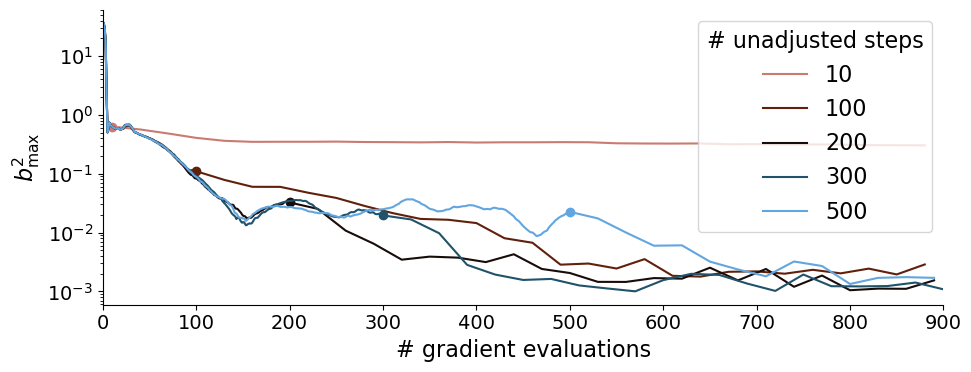

In [162]:
N = [10, 100, 200, 300, 500]

plt.figure(figsize= (10, 4))
for i, n in enumerate(N):
    print(i)
    x = np.load('img/trace/stop/GermanCredit_stop_at'+str(n)+'.npy')
    plt.plot(x[0], x[1], color=plt.cm.berlin_r((i + 0.5) / len(N)), label = str(n))
    plt.plot(x[0][n-1], x[1][n-1], 'o', color=plt.cm.berlin_r((i + 0.5) / len(N)))

plt.yscale('log')
plt.xlabel("# gradient evaluations")
plt.ylabel(r'$b^2_{\mathrm{max}}$')

plt.legend(title = '# unadjusted steps')
plt.xlim(0, 900)
plt.tight_layout()
plt.savefig('img/n1.pdf')
plt.show()

In [123]:
from collections import namedtuple

m = namedtuple('model', ['name', 'pretty_name', 'color'])


colors = {
        "Indigo": "#332288",
        "Sky Blue":"#88CCEE",
        "Teal": "#44AA99",
        "Orange": "#DDCC77",
        "Crimson": "#CC6677",
        "Olive": "#117733",
    }

models = [
    m('ICG_100_131258.94094081654', 'Ill Conditioned Gaussian', colors['Indigo']),
    m('vector_german_credit_numeric_sparse_logistic_regression', 'German Credit', colors['Crimson']),
    m('vector_synthetic_item_response_theory', 'Item Response Theory', colors['Olive']),
    m('Stochastic_Volatility_MAMS_Paper', 'Stochastic Volatility', colors['Orange']),
    ]

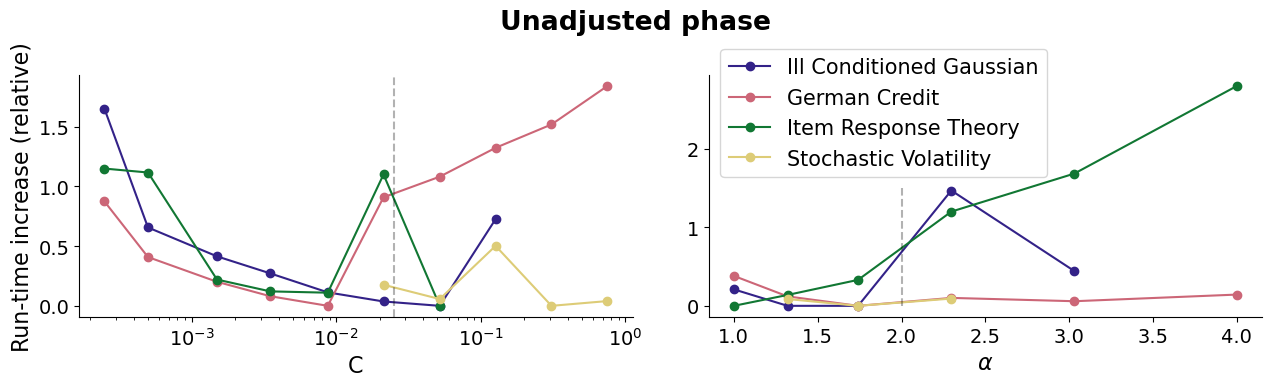

In [132]:
def _plot(hyp_name, hyp_pretty_name, extra_word='', fmt = 'o-', xmap= lambda x: x):
    for i, model in enumerate(models):
        
        try:
            file = 'img/trace/' + hyp_name + '/data' +model.name+ extra_word + '.csv'

            df = pd.read_csv(file, sep= '\t')
            x, y = xmap(np.array(df[hyp_name])), np.array(df[model.name])
            plt.plot(x, ((y / np.min(y)) - 1), fmt, color = model.color, label= model.pretty_name)
        except:
            None
    plt.xlabel(hyp_pretty_name)
    
plt.figure(figsize = (13, 4))
plt.suptitle('Unadjusted phase', fontweight = 'bold')

plt.subplot(1, 2, 1)
_plot('C', 'C', xmap= lambda x: x* 0.25)
plt.xscale('log')
plt.ylabel('Run-time increase (relative)')
plt.axvline(0.025, ls= '--', alpha = 0.3, color= 'black')
#plt.ylim(0, 600)

plt.subplot(1, 2, 2)
_plot('alpha', r'$\alpha$')
#plt.ylim(0, 600)
plt.tight_layout()
plt.legend(fontsize = 15, bbox_to_anchor=(0.63, 1.15))
plt.plot([2., 2.], [0, 1.5], ls= '--', alpha = 0.3, color= 'black')
plt.savefig('img/ablations1.pdf')
plt.show()

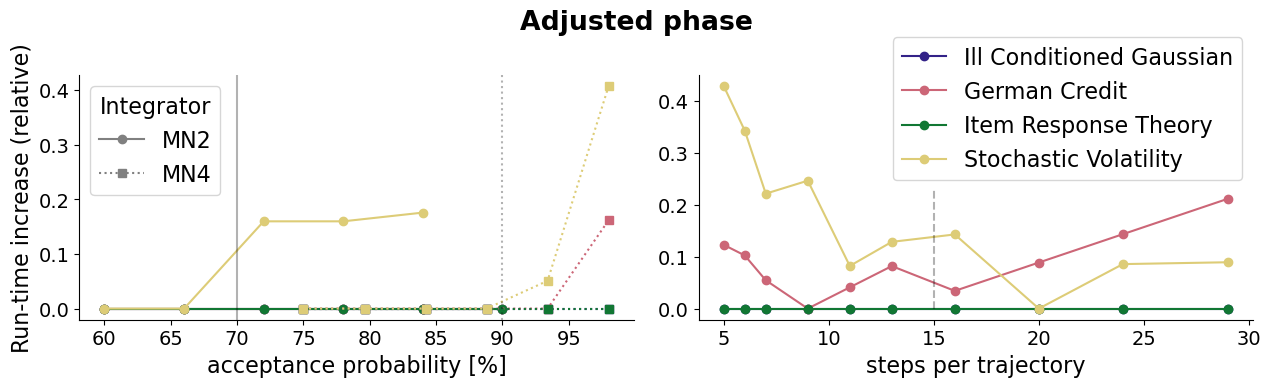

In [138]:
plt.figure(figsize = (13, 4))

plt.suptitle('Adjusted phase', fontweight = 'bold')

plt.subplot(1, 2, 1)
to_percent = lambda x: x * 100
_plot('acc_prob', 'acceptance probability [%]', extra_word= 'MN2', xmap = to_percent)
_plot('acc_prob', 'acceptance probability [%]', extra_word= 'MN4', fmt= 's:', xmap = to_percent)

plt.plot([], [], 'o-', color= 'Grey', label="MN2")
plt.plot([], [], 's:', color= 'Grey', label="MN4")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([], [], frameon=False)
plt.legend(handles[-2:], labels[-2:], title= 'Integrator')  
plt.ylabel('Run-time increase (relative)')
plt.axvline(70, ls= '-', alpha = 0.3, color= 'black')
plt.axvline(90, ls= ':', alpha = 0.3, color= 'black')

plt.subplot(1, 2, 2)
_plot('steps_per_sample', 'steps per trajectory')
#plt.legend(title= 'Model', fontsize = 15)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1.2))
plt.plot([15, 15], [0, 0.23], ls= '--', alpha = 0.3, color= 'black')
plt.savefig('img/ablations2.pdf')
plt.show()

In [ ]:
hyp_name= 'bias_type'
for i, model in enumerate(models):
    file = 'img/trace/' + hyp_name + '/data' +model.name+'.csv'
    df = pd.read_csv(file, sep= '\t')
    y = np.array(df[model.name])
    print(model.name, y[0]/y[1])

ICG_100_131258.94094081654 1.0031645569620253
vector_german_credit_numeric_sparse_logistic_regression 0.9544072948328267
vector_synthetic_item_response_theory 1.1022727272727273
Stochastic_Volatility_MAMS_Paper 1.0


In [ ]:

def plot_trace(info, model_name, settings_info, dir):
    

    with open(dir + model_name + '.pkl', 'rb') as f:
        info, settings_info = pickle.load(f)


    info1 = info['phase_1']
    info2 = info['phase_2'][0]


    n1 = info["phase_1"]["steps_done"] # info1['step_size'].shape[0]
    
    steps1 = jnp.arange(1, n1+1)
    steps2 = jnp.cumsum(info2['steps_per_sample']) * settings_info['num_grads_per_proposal'] + n1
    #steps2 = jnp.cumsum(info['phase_2'][0]['steps_per_sample']) * grads_per_step + n1

    steps = np.concatenate((steps1, steps2))
    ntotal = steps[-1]
    bias_max = np.concatenate((info1['bias0'][:n1], info2['bias'][:, 0]))
    bias_avg = np.concatenate((info1['bias1'][:n1], info2['bias'][:, 1]))


    st = samples_to_low_error(bias_max, 0.01)
    if np.isfinite(st):
        n = steps[st]
    else:
        n = np.inf


    plt.figure(figsize= (15, 5))

    def end_stage1():
        ax = plt.gca()
        ylim = ax.get_ylim()
        lw = ax.spines['bottom'].get_linewidth()
        color = ax.spines['bottom'].get_edgecolor()
        plt.plot((n1+1) * np.ones(2), ylim, color= color, lw= lw)
        plt.ylim(*ylim)
    
    ### bias ###
    plt.subplot(1, 2, 1)
    #plt.title('Bias')
    plt.plot([], [], '-', color= 'tab:red', label= 'max')
    plt.plot([], [], '-', color= 'tab:blue', label= 'average')
    
    # true
    plt.plot(steps, bias_avg, color = 'tab:blue')
    plt.plot(steps, bias_max, lw= 3, color = 'tab:red')
    plt.plot([], [], color='tab:gray', label= r'Second moments $b_t^2[x_i^2]$')

    # equipartition
    plt.plot(steps1, info1['equi_diag'][:n1], '.', color = 'tab:blue', alpha= 0.4)
    plt.plot([], [], '.', color= 'tab:gray', alpha= 0.4, label = r'Equipartition $B_t^2$')
    #plt.plot(steps1, info1['equi_full'], '.', color = 'tab:green', alpha= 0.4, label = 'full rank equipartition')
    #plt.plot(steps2, info2['equi_diag'], '.', color = 'tab:blue', alpha= 0.3)
    #plt.plot(steps2, info2['equi_full'], '.-', color = 'tab:green', alpha= 0.3)
    
    
    # relative fluctuations
    plt.plot(steps1, info1['r_avg'][:n1], '--', color = 'tab:blue')
    plt.plot(steps1, info1['r_max'][:n1], '--', color = 'tab:red')
    plt.plot([], [], '--', color = 'tab:gray',label = r'Fluctuations $\delta_t^2[x_i^2]$')

    plt.plot(steps1, info1['R_avg'][:n1], ':', color = 'tab:blue')
    plt.plot(steps1, info1['R_max'][:n1], ':', color = 'tab:red')
    plt.plot(steps2, info2['R_avg'], ':', color = 'tab:blue')
    plt.plot(steps2, info2['R_max'], ':', color = 'tab:red')
    plt.plot([], [], ':', color = 'tab:gray',label = 'split R')

    # pathfinder
    #pf= pd.read_csv('ensemble/submission/pathfinder_convergence.csv', sep= '\t')
    #pf_grads_all = np.array(pd.read_csv('ensemble/submission/pathfinder_cost.csv', sep= '\t')[model_name])
    #pf_grads = np.max(pf_grads_all) # in an ensemble setting we have to wait for the slowest chain

    # pf = pf[pf['name'] == model_name]
    # pf_bavg, pf_bmax = pf[['bavg', 'bmax']].to_numpy()[0]

    # if pf_bavg < 2 * np.max([np.max(bias), np.max(info1['equi_full']), np.max(info1['equi_diag'])]): # pathfinder has not converged
        
    #     plt.plot([pf_grads, ], [pf_bavg, ], '*', color= 'tab:blue')
    #     plt.plot([pf_grads, ], [pf_bmax, ], '*', color= 'tab:red')
    #     plt.plot([], [], '*', color= 'tab:gray', label= 'Pathfinder')
    
    # if annotations:
    #     plt.text(steps1[len(steps1)//2], 7e-4, 'Unadjusted', horizontalalignment= 'center')
    #     plt.text(steps2[len(steps2)//2], 7e-4, 'Adjusted', horizontalalignment= 'center')
        
  
    plt.ylim(2e-4, 2e2)
    
    plt.plot([0, ntotal], jnp.ones(2) * 1e-2, '-', color = 'black')
    plt.legend(fontsize= 12)
    plt.ylabel(r'$\mathrm{bias}^2$')
    plt.xlabel('# gradient evaluations')
    plt.xlim(0, ntotal)
    plt.yscale('log')
    end_stage1()
    
    ### stepsize tuning ###
    
    plt.subplot(3, 2, 2)
    #plt.title('Hyperparameters')
    plt.plot(steps1, info1['EEVPD'][:n1], '.', color='tab:orange')
    plt.plot([], [], '-', color= 'tab:orange', label= 'observed')
    plt.plot(steps1, info1['EEVPD_wanted'][:n1], '-', color='black', alpha = 0.5, label = 'targeted')

    plt.legend(loc=4, fontsize=10)
    plt.ylabel("EEVPD")
    plt.yscale('log')
    
    ylim = plt.gca().get_ylim()
    end_stage1()
    
    ax = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
    ax.spines['right'].set_visible(True)
    ax.plot(steps2, info2['acc_prob'], '.', color='tab:orange')
    ax.plot([steps1[-1], steps2[-1]], settings_info['acc_rate'] * np.ones(2), '-', alpha= 0.5, color='black')    
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('acc prob')
    ax.tick_params(axis='y')
        
    plt.subplot(3, 2, 4)
    plt.plot(steps1, info1['step_size'][:n1], '.', color='tab:orange')
    plt.plot(steps2, info2['step_size'], '.', color='tab:orange')
    plt.ylabel(r"step size")
    #plt.yscale('log')
    end_stage1()
    
    ### L tuning ###
    plt.subplot(3, 2, 6)
    # L0 = jnp.sqrt(jnp.sum(model.E_x2))
    plt.plot(steps1, info1['L'][:n1], '.', color='tab:green')
    plt.plot(steps2, info2['L'], '.', color='tab:green')
    #plt.plot([0, ntotal], L0 * jnp.ones(2), '-', color='black')
    end_stage1()
    plt.ylabel("L")
    #plt.yscale('log')
    plt.xlabel('# gradient evaluations')
    
    plt.tight_layout()
    plt.savefig(dir + model_name + '.png')
    plt.close()

    return n
